# BEE 4750 Homework 5: Solid Waste Disposal

**Name**: Emma Rose Connolly

**ID**: erc76

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [104]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/classes/Semester 5/BEE 4750/homework/hw05-Erc03`


In [105]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using LaTeXStrings

## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee ** (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:-------------:|:-------------:|:-------------:|:----------:|:--------------:|
|           Landfill           |         200         |         2000          |            50            |                            |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |                            |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:---------------------:|:--------------:|:---------------:|:---------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

In [106]:
#ash fraction
ash = (0.08*.15)+(.07*.4)+(0.05*0.05)+(0.1*0.03)+(.15*.02)+(.02*.05)+(.02*.18)+(1*.04)+(1*.02)+(1*.02)+(1*.01)+(.7*.03)

#recycling fraction
recycling = (.15*0)+(.40*.55)+(.05*.15)+(0.03*.1)+(.02*0)+(.05*.30)+(.18*.40)+(.04*.60)+(.02*.75)+(.02*.8)+(.01*.5)+(.03*0)

print("The fractions of ash: ", round(ash; digits = 4))
print("\nThe fractions of recycling: ", round(recycling; digits = 4))

The fractions of ash: 0.1641
The fractions of recycling: 0.3775

#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

> The decision variable for the optimization problem are:
> 
> $W_{i,j}$ - Waste transported from city i to disposal j (Mg/day)
>
> $R_{k,j}$ - Residual waste transported from disposal k to disposal j (Mg/day)
>
> $Y_j$ - 	Operational status (on/off) of disposal j (binary)

#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).

For this function we are looking to find the minimzation of total cost. To do this, we first need to find a formula for the transportation costs. To do this, we will look at the summation of $a_{i,j}$, $l_{i,j}$, and $W_{i,j}$

\begin{align}
&\text {Transportation Cost = $\sum_{i \in I, j \in J} a_{i,j} \ast l_{i,j} \ast W_{i,j}$} \notag
\end{align}

where:

$a_{i,j}$ - Cost of transporting waste from source i to disposal j (dollars/Mg-km)

$l_{i,j}$ - Distance between source i and disposal j (km)



Next, we will find the equation for each disposal cost. For this, we will have another summation.

\begin{align}
&\text {Disposal Cost = $\sum_{j \in J}[c_j + b_j \ast \sum_{i \in I} W_{i,j}] $} \notag
\end{align}

where:

$c_j$ - Fixed costs of operating disposal j ($/day)

$b_j$ - Variable cost of disposing waste at disposal j ($/Mg)


Inputting all givens we can now look for the total cost:

Summing all these:
\begin{align}
&\text {LF = $2000Y_1 + +50(W_{1,1}+W_{2,1}+W_{3,1}+R_{2,1}+R_{3,1})  $} \notag
&&\\
&\text {MRF = $1500Y_2 + (7+(40*0.3775))(W_{1,2}+W_{2,2}+W_{3,2}) $} \notag
&&\\ 
&\text {WTE = $2500Y_3 +60(W_{1,3}+W_{2,3}+W_{3,3} + R_{2,3}) $ } \notag
&&\\ \notag
&&\\ \notag
&\text {Trans. Cost = $1.5[5(W_{1,1})+30(W_{1,2})+15(W_{1,3})+15(W_{2,1})+25(W_{2,2})+10(W_{2,3})+13(W_{3,1})+45(W_{3,2})+20(W_{3,3})+15(R_{2,3})+32(R_{2,1})+18(R_{3,1})] $} \notag
&&\\ \notag
&&\\ \notag
&\text {Total Cost = $2000Y_1 +1500Y_2 + 2500Y_3 + 57.5(W_{1,1})+67.1(W_{1,2})+82.5(W_{1,3})+72.5(W_{2,1})+59.6(W_{2,2})+75(W_{2,3})+69.5(W_{3,1})+89.6(W_{3,2})+90(W_{3,3})   $} \notag
&&\\ 
&\text {$+82.5(R_{2,3})+98(R_{2,1})+77(R_{3,1}) $} \notag
\end{align}





The only way this above equation is correct if all disposal facilities are operating. The option to not operate disposal facility j means we need new indicator variables.


\begin{equation}
Y_j =
\begin{cases}
    0 & \text{if } \sum_{i \in I}W_ij = 0 \\ 
    1 & \text{if } \sum_{i \in I}W_ij > 0 \notag
\end{cases}
\end{equation}


#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

For this function, we have two constraints:

1. Need to dispose of all waste from each source i:

\begin{align}
\sum_{j \in J} W_{i,j} = S_i \notag
\end{align}

2. Total waste per day from each city i:
\begin{align}
\text{$\sum_{j \in J} W_{1,j}= 100$ Mg/day}\notag
\\
\text{$\sum_{j \in J} W_{2,j} = 90$ Mg/day}\notag
\\
\text{$\sum_{j \in J} W_{3,j} = 120$ Mg/day}\notag
\end{align}

3. Capacity limit (K) at each disposal site j:

\begin{align}
\sum_{i \in I} W_{i,j} \leq K_j \notag
\end{align}

\begin{align}
&\text{$\sum_{i \in I} W_{i,1} + \sum_{i \in I} R_{i,1} \leq 200$ - Landfill}\notag
&&\\
&\text{$\sum_{i \in I} W_{i,2} + \sum_{i \in I} R_{i,2} \leq 350$ - Materials Recycling Facility}\notag
&&\\
&\text{$\sum_{i \in I} W_{i,3} + \sum_{i \in I} R_{i,2} \leq 210$ - Waste to Energy}\notag
\end{align}


3. $W_{i,j}$ and $R_{i,j}$ cannot be negative:

\begin{align}
\sum_{i \in I, j \in J} W_{i,j} \ge 0 \notag
\sum_{i \in I, j \in J} R_{i,j} \ge 0 \notag
\end{align}

4. Not all waste will burn the same - the ash rate depends on the waste composition; residual mass balances are needed:
\begin{align}
\frac{\sum (fraction of waste \ast (1-MRF rate) \ast (ash rate))}{\sum (fraction of waste \ast (1-MRF rate))} \notag
\end{align}

To find this, we can use a Excel. 

In the spreadsheet, the numerator and denominator of the fraction were calculated for each waste component. Then, the numerators and denominators were summed up and divided to get the fraction. Here is a sample calculation for food wastes:

\begin{align}
\text{Numerator: } \notag
\text{$0.15 \ast (1-0) \ast (0.08)$} \notag
\\
\text{Denominator: } \notag
\text{$0.15 \ast (1-0)$} \notag
\end{align}

For this we get that the fraction is 0.1386.

If there is any confusion in how the spreadsheet was used, please consult the link:
https://docs.google.com/spreadsheets/d/13S6avwG-Aa9AKlzOupBtSy7bKXNN49PI86VcmSDRTOw/edit?usp=sharing


Using this we will include this in the residual mass balance for waste to energy:
\begin{align}
\text{$R_{3,1}=ashpercent*(W_{1,3}+W_{2,3}+W_{3,3})+(0.1386*R_{2,3})$} \notag
\end{align}

Additionally, a residual mass balance is required for material recycling facility:
\begin{align}
\text{$R_{2,1}+R_{2,3}=(1-recyclepercent)*(W_{1,2}+W_{2,2}+W_{3,2})$} \notag
\end{align}


6. Commitment (need to use Big M):
The addition of the Big M constraint allows us to be able to better see changes made in the model. Big M is a large value.
\begin{align}
&\text {$M=1000$}\notag
&&\\
&\text {$M*\sum_{j \in J} Y_{j} \ge \sum_{j \in J}K_{j}$}\notag
&&\\
&\text{$M*Y_1 \ge \sum_{i \in I} W_{i,1} + \sum_{i \in I} R_{i,1}$ - Landfill}\notag
&&\\
&\text{$M*Y_2 \ge \sum_{i \in I} W_{i,2} + \sum_{i \in I} R_{i,2}$ - Materials Recycling Facility}\notag
&&\\
&\text{$M*Y_3 \ge \sum_{i \in I} W_{i,3} + \sum_{i \in I} R_{i,3}$ - Waste to Energy}\notag
\end{align}


No, I would not recommend the cities build the new landfill. The addition of the new landfill reduces the total cost by approximately $600, so it is barely any change in cost. The additional cost of adding the landfill will cost the cities more than it will pay off. 


#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [117]:
# Packages being used
using JuMP
using HiGHS

# Create a JuMP model with the HiGHS solver to optimize our model
waste=Model(HiGHS.Optimizer)
I=1:3
J=1:3
K=1:3

#define decision variables
@variable(waste, W[i in I, j in J] >= 0) #units: Mg/day
@variable(waste, R[k in K, j in J] >= 0) #units: Mg/day
@variable(waste, Y[j in J],Bin)


#define objective As derived above
@objective(waste, Min, 2000*Y[1]+1500*Y[2]+ 2500*Y[3]+57.5(W[1,1])+67.1(W[1,2])+82.5(W[1,3])+72.5(W[2,1])+59.6(W[2,2])+75(W[2,3])+69.5(W[3,1])
+89.6(W[3,2])+90(W[3,3])+22.5(R[2,3])+98(R[2,1])+77(R[3,1])+82.5(R[2,3])+98(R[2,1])+77(R[3,1]))

#Constraints
#City Mass Balance 
@constraint(waste, city1, W[1,1]+W[1,2]+W[1,3]==100); #Mg/day
@constraint(waste, city2, W[2,1]+W[2,2]+W[2,3]==90); #Mg/day
@constraint(waste, city3, W[3,1]+W[3,2]+W[3,3]==120); #Mg/day

#Residual Mass Balance 
@constraint(waste, WTEReturn, R[3,1]==ash*(W[1,3]+W[2,3]+W[3,3])+0.1386*R[2,3]); #0.1386 is from excel calculation
@constraint(waste, MRFReturn, R[2,1]+R[2,3]==(1-recycling)*(W[1,2]+W[2,2]+W[3,2])); #(1-recycling fraction)

#Disposal Limit 
@constraint(waste, LF, W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]<=200); 
@constraint(waste, MRF, W[1,2]+W[2,2]+W[3,2]<=350); 
@constraint(waste, WTE, W[1,3]+W[2,3]+W[3,3]+R[2,3]<=210);

#Commitment 
M=1000 #Big M Reformulation 
@constraint(waste, commit1, M*Y[1] >= W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]);
@constraint(waste, commit2, M*Y[2] >= W[1,2]+W[2,2]+W[3,2]);
@constraint(waste, commit3, M*Y[3] >= W[1,3]+W[2,3]+W[3,3]+R[2,3]);


print(waste)

Min 2000 Y[1] + 1500 Y[2] + 2500 Y[3] + 57.5 W[1,1] + 67.1 W[1,2] + 82.5 W[1,3] + 72.5 W[2,1] + 59.6 W[2,2] + 75 W[2,3] + 69.5 W[3,1] + 89.6 W[3,2] + 90 W[3,3] + 105 R[2,3] + 196 R[2,1] + 154 R[3,1]
Subject to
 city1 : W[1,1] + W[1,2] + W[1,3] = 100
 city2 : W[2,1] + W[2,2] + W[2,3] = 90
 city3 : W[3,1] + W[3,2] + W[3,3] = 120
 WTEReturn : -0.16410000000000002 W[1,3] - 0.16410000000000002 W[2,3] - 0.16410000000000002 W[3,3] + R[3,1] - 0.1386 R[2,3] = 0
 MRFReturn : -0.6224999999999998 W[1,2] - 0.6224999999999998 W[2,2] - 0.6224999999999998 W[3,2] + R[2,1] + R[2,3] = 0
 commit1 : -W[1,1] - W[2,1] - W[3,1] - R[2,1] - R[3,1] + 1000 Y[1] ≥ 0
 commit2 : -W[1,2] - W[2,2] - W[3,2] + 1000 Y[2] ≥ 0
 commit3 : -W[1,3] - W[2,3] - W[3,3] - R[2,3] + 1000 Y[3] ≥ 0
 LF : W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] ≤ 200
 MRF : W[1,2] + W[2,2] + W[3,2] ≤ 350
 WTE : W[1,3] + W[2,3] + W[3,3] + R[2,3] ≤ 210
 W[1,1] ≥ 0
 W[2,1] ≥ 0
 W[3,1] ≥ 0
 W[1,2] ≥ 0
 W[2,2] ≥ 0
 W[3,2] ≥ 0
 W[1,3] ≥ 0
 W[2,3] ≥ 0
 W[

#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [108]:
optimize!(waste)

print("The minimum cost is ", round(objective_value(waste), digits =2), " dollars")

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
10 rows, 15 cols, 43 nonzeros
8 rows, 13 cols, 35 nonzeros

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   35 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   2000            inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   2000            29518.273119      93.22%        0      0      0         0     0.0s
         0       0         0   0.00%   27672.354775    29518.273119       6.25%        0      0      0         5     0.0s

Solving report
  Status            Optimal
  Primal bound      29518.2731188
  Dual bound        29518.2731188
  Gap           

In [109]:
#how much of each city's waste goes to each disposal sight
value.(W.data)

3×3 Matrix{Float64}:
 100.0      0.0   0.0
  -0.0     -0.0  90.0
  78.4053   0.0  41.5947

In [110]:
#residual values
value.(R.data)

3×3 Matrix{Float64}:
  0.0     0.0  0.0
  0.0     0.0  0.0
 21.5947  0.0  0.0

#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

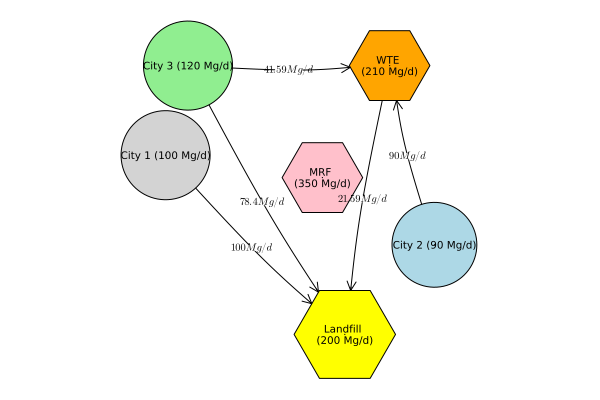

In [111]:
using GraphRecipes, Plots

A = [0 0 0 1 0 0 ;
    0 0 0 0 0 1 ;
    0 0 0 1 0 1 ;
    0 0 0 0 0 0 ;
    0 0 0 0 0 0 ;    
    0 0 0 1 0 0 ]

names = ["City 1 (100 Mg/d)", "City 2 (90 Mg/d)", "City 3 (120 Mg/d)", "Landfill \n(200 Mg/d)", "MRF \n(350 Mg/d)", "WTE \n(210 Mg/d)"]
# modify this dictionary to add labels
edge_labels = (Dict((1, 4) => L"100 Mg/d", (2,6) => L"90 Mg/d", (6, 4) => L"21.59 Mg/d", 
            (3, 6) => L"41.59 Mg/d",(3, 4) => L"78.4 Mg/d"))
shapes=[:circle, :circle, :circle, :hexagon, :hexagon, :hexagon]
colors=[:lightgrey, :blues, :lightgreen, :yellow, :pink, :orange]
xpos = [-1, 2., -0.75, 1, .75, 1.5]
ypos = [1, 0, 2, -1, .75, 2]

graphplot(A, names=names, edgelabel=edge_labels, edgelabels_boxes = true, fontsize = 7, markersize=0.23, markercolors=colors, markershapes=shapes, x=xpos, y=ypos)

Note: this diagram is not drawn to 

From the optimization of the model, the MRF facility is not used. This makes sense because the facility is far from each of the cities, so the transportation cost would be a lot if the facility was in use. The other two, although they may cost more upfront, they are closer to the cities, so the transportation costs is less.

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

The first major change that needs to be made is that we have to account for the fact that there are now 4 disposal sites (j=4). This means that we have to re-derive the costs for each and also the toal cost:

\begin{align}
&\text {LF1 = $2000Y_1 + 50(W_{1,1}+W_{2,1}+W_{3,1}+R_{2,1}+R_{3,1})  $} \notag
&&\\
&\text {LF2 = $2000Y_4 + 60(W_{1,4}+W_{2,4}+W_{3,4}+R_{2,4}+R_{3,4})  $} \notag
&&\\
&\text {MRF = $1500Y_2 + (7+(40*0.3775))(W_{1,2}+W_{2,2}+W_{3,2}) $} \notag
&&\\ 
&\text {WTE = $2500Y_3 +75(W_{1,3}+W_{2,3}+W_{3,3}+R_{2,3}) $ } \notag
&&\\ \notag
&&\\ \notag
&\text {Trans. Cost = $2[5(W_{1,1})+30(W_{1,2})+15(W_{1,3})+45(W_{1,4})+15(W_{2,1})+25(W_{2,2})+10(W_{2,3})+35(W_{2,4})+13(W_{3,1})+45(W_{3,2})+20(W_{3,3})+15(W_{3,4})+15(R_{2,3})$}\notag
&&\\ \notag
&\text{$+32(R_{2,1})+35(R_{2,4})+18(R_{3,1})+50(R_{3,4})] $} \notag
&&\\ \notag
&&\\ \notag
&\text {Total Cost = $2000Y_1 +1500Y_2 + 2500Y_3 + 2500Y_4 + 60(W_{1,1})+82.1(W_{1,2})+105(W_{1,3})+150(W_{1,4})+80(W_{2,1})+72.1(W_{2,2})+95(W_{2,3})+130(W_{2,4})+76(W_{3,1})+112.1(W_{3,2})+115(W_{3,3})+160(W_{3,4})   $} \notag
&&\\ 
&\text {$+105(R_{2,3})+114(R_{2,1})+86(R_{3,1})+130(R_{2,4})+160(R_{3,4}) $} \notag
\end{align}


There will also be changes to the constraints because j = 4:

1. Total waste per day from each city i:
\begin{align}
\text{$\sum_{j \in 4} W_{1,j}= 100$ Mg/day}\notag
\\
\text{$\sum_{j \in 4} W_{2,j} = 90$ Mg/day}\notag
\\
\text{$\sum_{j \in 4} W_{3,j} = 120$ Mg/day}\notag
\end{align}

2. The residual mass balance will include LF<sub>2</sub>:

This means that all residuals for LF<sub>2</sub> must be added to the equations for the mass balance: R[3,4] for waste to energy and R[2,4] for the materials recycling facility. Additionally, we will includ the fraction found in question 1 to account for the fact that not all waste burns at the same rate. 

So, the residual mass balance for waste to energy:
\begin{align}
\text{$R_{3,1}+R_{3,4}=ashpercent*(W_{1,3}+W_{2,3}+W_{3,3})+(0.1386*R_{2,3})$} \notag
\end{align}

And, the residual mass balance for material recycling facility:
\begin{align}
\text{$R_{2,1}+R_{2,3}+R_{2,4}=(1-recyclepercent)*(W_{1,2}+W_{2,2}+W_{3,2})$} \notag
\end{align}

3. The addition fo the new landfill ot the disposal limit:

The disposal limit constraints will be edited as below to include the new landfill's maximum intake:
\begin{align}
&\text{$\sum_{i \in I} W_{i,1} + \sum_{i \in I} R_{i,1} \leq 100$ - Landfill 2}\notag
&&\\
&\text{Note Residual $R_{1,4}$ and $R_{4,1}$ is not applicable for this problem because there would be no residual going from landfill to the other}\notag
\end{align}


4. An additional commitment constraint 
\begin{align}
&\text{$M*Y_4 \ge \sum_{i \in I} W_{i,4} + \sum_{i \in I} R_{i,4}$ - Landfill 2}\notag
&&\\
&\text{Note Residual $R_{1,4}$ and $R_{4,1}$ is not applicable for this problem because there would be no residual going from landfill to the other}\notag
\end{align}



#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [118]:
using JuMP
using HiGHS


# Create a JuMP model with the HiGHS solver to optimize our model
waste=Model(HiGHS.Optimizer)
I=1:3
J=1:4
K=1:4

#define decision variables
@variable(waste, W[i in I, j in J] >= 0) #units: Mg/day
@variable(waste, R[k in K, j in J] >= 0) #units: Mg/day
@variable(waste, Y[j in J],Bin)

#defining objective as above
@objective(waste, Min, 2000*Y[1]+1500*Y[2]+ 2500*Y[3]+2000*Y[4]+60(W[1,1])+ 82.1(W[1,2])+105(W[1,3])+150(W[1,4])+80(W[2,1])
+72.1(W[2,2])+95(W[2,3])+130(W[2,4])+76(W[3,1])+112.1(W[3,2])+115(W[3,3])+160(W[3,4])+105(R[2,3])+114(R[2,1])+130(R[2,4])+86(R[3,1])+160(R[3,4]))

#constraints
#City Mass Balance 
@constraint(waste, city1, W[1,1]+W[1,2]+W[1,3]+W[1,4]==100);
@constraint(waste, city2, W[2,1]+W[2,2]+W[2,3]+W[2,4]==90);
@constraint(waste, city3, W[3,1]+W[3,2]+W[3,3]+W[3,4]==120);

#Residual Mass Balance 
@constraint(waste, WTEReturn, R[3,1]+R[3,4]==ash*(W[1,3]+W[2,3]+W[3,3])+0.1386*R[2,3]); #from excel calculation
@constraint(waste, MRFReturn, R[2,1]+R[2,3]+R[2,4]==(1-recycling)*(W[1,2]+W[2,2]+W[3,2])); 

#Disposal Limit 
@constraint(waste, LF1, W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]<=200); 
@constraint(waste, MRF, W[1,2]+W[2,2]+W[3,2]<=350); 
@constraint(waste, WTE, W[1,3]+W[2,3]+W[3,3]+R[2,3]<=210);
@constraint(waste, LF2, W[1,4]+W[2,4]+W[3,4]+R[2,4]+R[3,4]<=100); 

#Commitment 
M=1000 #Big M Reformulation Needed
@constraint(waste, commit1, M*Y[1] >= W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]);
@constraint(waste, commit2, M*Y[2] >= W[1,2]+W[2,2]+W[3,2]);
@constraint(waste, commit3, M*Y[3] >= W[1,3]+W[2,3]+W[3,3]+R[2,3]);
@constraint(waste, commit4, M*Y[4] >= W[1,4]+W[2,4]+W[3,4]+R[2,4]+R[3,4]);

#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [119]:
optimize!(waste)
print("The minimum cost is ", round(objective_value(wastep2), digits =2), " dollars")

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
12 rows, 21 cols, 59 nonzeros
12 rows, 21 cols, 59 nonzeros

Solving MIP model with:
   12 rows
   21 cols (4 binary, 0 integer, 0 implied int., 17 continuous)
   59 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   0               31649.336045     100.00%        0      0      0         0     0.0s
         0       0         0   0.00%   28481.410233    31649.336045      10.01%        0      0      0         9     0.0s

Solving report
  Status            Optimal
  Primal bound      31649.336045
  Dual bound        31649.336045
  Gap           

In [114]:
#how much of each city's waste goes to each disposal sight
value.(W.data)

3×4 Matrix{Float64}:
 100.0      0.0   0.0      0.0
   0.0     -0.0  90.0     -0.0
  78.4053   0.0  41.5947   0.0

In [115]:
#residual values
value.(R.data)

4×4 Matrix{Float64}:
  0.0     0.0  0.0  0.0
  0.0     0.0  0.0  0.0
 21.5947  0.0  0.0  0.0
  0.0     0.0  0.0  0.0

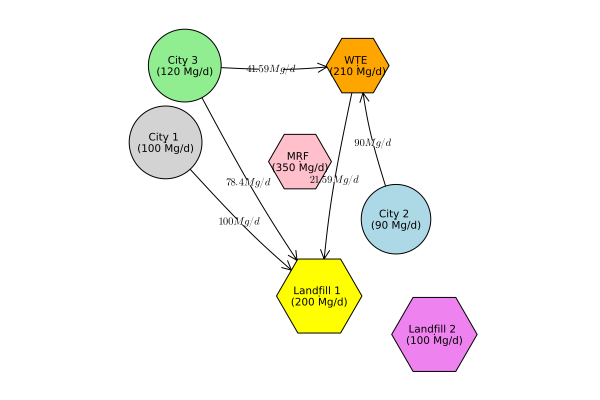

In [116]:
using GraphRecipes, Plots

A = [0 0 0 1 0 0 0;
    0 0 0 0 0 1 0;
    0 0 0 1 0 1 0;
    0 0 0 0 0 0 0;
    0 0 0 0 0 0 0;    
    0 0 0 1 0 0 0;
    0 0 0 0 0 0 0]

names = ["City 1 \n(100 Mg/d)", "City 2 \n(90 Mg/d)", "City 3 \n(120 Mg/d)", "Landfill 1 \n(200 Mg/d)", "MRF \n(350 Mg/d)", "WTE \n(210 Mg/d)", "Landfill 2 \n(100 Mg/d)"]
# modify this dictionary to add labels
edge_labels = (Dict((1, 4) => L"100 Mg/d", (2,6) => L"90 Mg/d", (6, 4) => L"21.59 Mg/d", 
            (3, 6) => L"41.59 Mg/d",(3, 4) => L"78.4 Mg/d"))
shapes=[:circle, :circle, :circle, :hexagon, :hexagon, :hexagon, :hexagon]
colors=[:lightgrey, :blues, :lightgreen, :yellow, :pink, :orange, :violet]
xpos = [-1, 2., -0.75, 1, .75, 1.5, 2.5]
ypos = [1, 0, 2, -1, .75, 2, -1.5]

graphplot(A, names=names, edgelabel=edge_labels, edgelabels_boxes = true, fontsize = 7, markersize=0.23, markercolors=colors, markershapes=shapes, x=xpos, y=ypos)

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

No, I would not recommend the cities build the new landfill. The addition of the new landfill reduces the total cost by approximately $600, so it is barely any change in cost. Additionally, the facility is not even used in the optimization of the system. Currently, it does not make sense for the cities to add the landfill because the costs outweight the benefit. My recommendation may change if there were different circumstances. For instance, if more waste was beings produced, then the additional facility might be needed. Also, if there were more regulations on the waste allowed to go to the WTE facility, the cities may have to add the landfill to ensure they are within the regulations. 

## References

List any external references consulted, including classmates.

I worked with Teagan Smith and went to Gabriela's OH. 